# Projet de DataScience - Classification de l'éligibilité aux prêts

### Introduction

<p align="right"> Dans le cadre du projet de Data Science 2025, nous cherchons à prédire l’éligibilité aux prêts bancaires à partir du jeu de données « Loan Eligible Dataset » issu de Kaggle. Ce jeu de données, déjà séparé en ensembles d’entraînement et de test, contient des informations socio-économiques et financières sur des demandeurs de prêt.

Notre démarche suit les étapes classiques d’un projet de machine learning :
- Exploration et préparation des données (nettoyage, création de variables, gestion des valeurs manquantes)
- Sélection des variables pertinentes pour la prédiction
- Entraînement et comparaison de plusieurs modèles de classification (Random Forest, Gradient Boosting, Régression Logistique, Naive Bayes)
- Évaluation des performances à l’aide de métriques adaptées (accuracy, F1-score, AUC)
- Optimisation du modèle retenu et interprétation des résultats

L’objectif final est de proposer un modèle robuste et interprétable, capable d’assister efficacement les établissements bancaires dans la prise de décision concernant l’octroi de prêts, tout en documentant clairement chaque étape du processus.</p>

### Import des librairies necessaires 

In [37]:
# Importation des librairies nécessaires pour la manipulation des données, le prétraitement et la modélisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, f1_score, ConfusionMatrixDisplay
)
import warnings
warnings.filterwarnings('ignore')

### Chargement des données et nettoyage initial

In [38]:
print("Chargement des données...")
train_data = pd.read_csv(r"C:\Users\diack\OneDrive\Documents\Projet_data_Aida_Basilia\dataset_loan_eligibility\loan-train.csv")
test_data = pd.read_csv(r"C:\Users\diack\OneDrive\Documents\Projet_data_Aida_Basilia\dataset_loan_eligibility\loan-test.csv")

# Suppression de la colonne identifiant car inutile pour l'analyse de données
print("\nSuppression de la colonne d'identifiant...")
train_data = train_data.drop(columns=['Loan_ID'])
test_data = test_data.drop(columns=['Loan_ID'])

# Remplacement des valeurs '3+' par '3' dans la colonne 'Dependents' pour faciliter l'analyse de données
print("\nRemplacement de '3+' par '3' dans 'Dependents'...")
train_data['Dependents'] = train_data['Dependents'].replace('3+', '3')
test_data['Dependents'] = test_data['Dependents'].replace('3+', '3')

# Affichage rapide des premières lignes et des infos générales
print("\nAperçu du jeu d'entraînement :")
display(train_data.head())
print(f"Train : {train_data.shape[0]} lignes, {train_data.shape[1]} colonnes")
print(f"Test  : {test_data.shape[0]} lignes, {test_data.shape[1]} colonnes")


Chargement des données...

Suppression de la colonne d'identifiant...

Remplacement de '3+' par '3' dans 'Dependents'...

Aperçu du jeu d'entraînement :


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


Train : 614 lignes, 12 colonnes
Test  : 367 lignes, 11 colonnes


### Distribution de la cible


Distribution de la variable cible avant équilibrage (Loan_Status) :


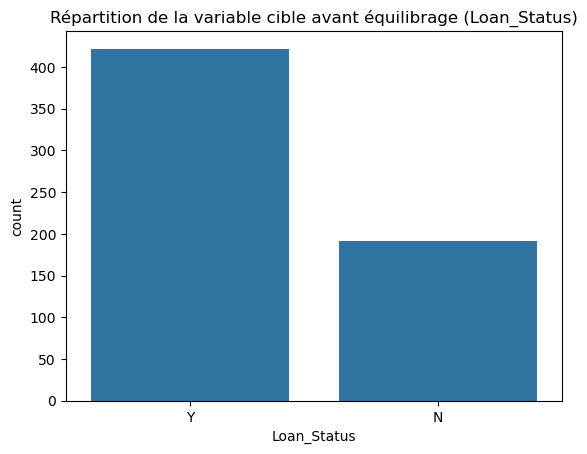

In [39]:
# distribution avant équilibrage
print("\nDistribution de la variable cible avant équilibrage (Loan_Status) :")
sns.countplot(x='Loan_Status', data=train_data)
plt.title("Répartition de la variable cible avant équilibrage (Loan_Status)")
plt.show()

Le graphique ci-dessus montre la répartition de la variable cible **Loan_Status** avant équilibrage :

- La classe "Y" (prêt accordé) est majoritaire, avec environ 420 dossiers.

- La classe "N" (prêt refusé) est minoritaire, avec environ 190 dossiers.

Cela signifie que le jeu de données est déséquilibré : il y a beaucoup plus de cas où le prêt est accordé que de cas où il est refusé.

**Conséquence** :
Cet important déséquilibre peut biaiser les modèles de classification, qui risquent alors de prédire plus souvent la classe majoritaire ("Y") et de mal détecter les refus ("N").
C’est pourquoi il sera nécessaire d’utiliser des techniques de rééquilibrage avant l’entraînement des modèles.



### Feature engineering et analyse exploratoire


Matrice de corrélation (variables numériques) :


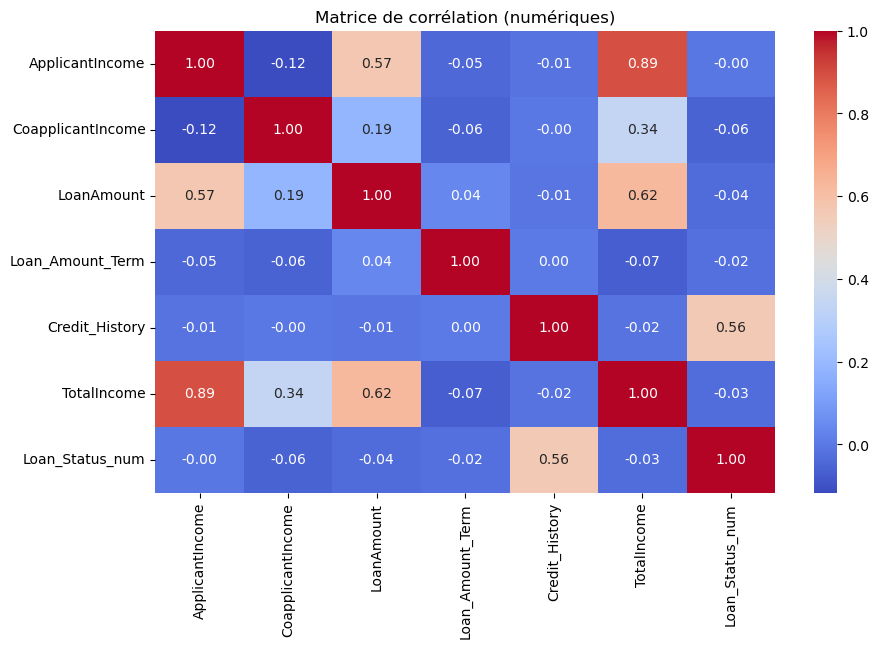


Corrélation avec la cible :
 Credit_History       0.561678
ApplicantIncome     -0.004710
Loan_Amount_Term    -0.021268
TotalIncome         -0.031271
LoanAmount          -0.037318
CoapplicantIncome   -0.059187
Name: Loan_Status_num, dtype: float64


In [40]:
# Création d'une nouvelle variable 'TotalIncome'
train_data['TotalIncome'] = train_data['ApplicantIncome'] + train_data['CoapplicantIncome']
test_data['TotalIncome'] = test_data['ApplicantIncome'] + test_data['CoapplicantIncome']

# Conversion de la cible pour la corrélation
df_corr = train_data.copy()
df_corr['Loan_Status_num'] = train_data['Loan_Status'].map({'Y': 1, 'N': 0})

# Matrice de corrélation
print("\nMatrice de corrélation (variables numériques) :")
corr = df_corr.corr(numeric_only=True)
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation (numériques)")
plt.show()

corr_with_target = corr['Loan_Status_num'].drop('Loan_Status_num').sort_values(ascending=False)
print("\nCorrélation avec la cible :\n", corr_with_target)


<p align="right">Nous avons créé une nouvelle variable, TotalIncome, qui correspond au revenu total du demandeur en additionnant son revenu personnel et celui du co-demandeur. Cela permet de mieux refléter la capacité financière globale.

Ensuite, nous avons converti la variable cible en numérique pour pouvoir calculer la corrélation avec les autres variables.

Le graphique montre les relations entre les différentes variables numériques :
- L’historique de crédit **(Credit_History)** est clairement la variable la plus liée à la décision d’octroi du prêt. Plus cette valeur est bonne, plus la probabilité d’obtenir un prêt est élevée.
- Les autres variables comme les revenus ou le montant du prêt ont une corrélation faible avec la cible, ce qui signifie qu’elles n’influencent pas directement la décision, ou que leur effet est plus complexe.
- On remarque aussi que ApplicantIncome et TotalIncome sont très liés, ce qui est logique puisque TotalIncome inclut ApplicantIncome.

En résumé, l’historique de crédit est un indicateur clé dans ce jeu de données, tandis que les autres variables numériques apportent un complément d’information qui pourra aider les modèles à mieux prédire.</p>

### Analyse des variables catégorielles (test du chi²)

In [41]:
from scipy.stats import chi2_contingency
cat_vars = ['Gender', 'Married', 'Education', 'Self_Employed', 'Dependents', 'Property_Area']
print("\nTest du chi2 entre chaque variable catégorielle et la cible :")
for var in cat_vars:
    table = pd.crosstab(train_data[var], train_data['Loan_Status'])
    chi2, p, dof, expected = chi2_contingency(table)
    print(f"{var:15} - p-value du Khi2 : {p:.4f}")



Test du chi2 entre chaque variable catégorielle et la cible :
Gender          - p-value du Khi2 : 0.7087
Married         - p-value du Khi2 : 0.0344
Education       - p-value du Khi2 : 0.0431
Self_Employed   - p-value du Khi2 : 1.0000
Dependents      - p-value du Khi2 : 0.3679
Property_Area   - p-value du Khi2 : 0.0021


Pour chaque variable catégorielle, nous avons testé s’il existe une association statistique avec la décision d’octroi du prêt (`Loan_Status`) à l’aide du test du chi².

- **Hypothèse** : il existe un **lien** entre la variable et la décision d’octroi si et seulement si le p-value < 0,05.

- **Property_Area**, **Married** et **Education** : p-value < 0,05 → ces variables sont liées à la décision d’octroi.
- **Gender**, **Self_Employed** et **Dependents** : p-value > 0,05 → pas de lien significatif détecté.

**En résumé :**  
La localisation, le statut matrimonial et le niveau d’études semblent influencer la décision de la banque, contrairement au sexe ou au nombre de personnes à charge.


### Préparation des features et du target

In [42]:
# Identification des types de colonnes
num_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
bin_cat_cols = ['Gender', 'Married', 'Education', 'Self_Employed']
multi_cat_cols = ['Dependents', 'Property_Area']
target_col = 'Loan_Status'

# Séparation features/target
X_train = train_data.drop(columns=[target_col])
y_train = train_data[target_col]
X_test = test_data.copy()

# Encodage de la variable cible
label_encoder_target = LabelEncoder()
y_train_encoded = label_encoder_target.fit_transform(y_train)

# Affichage du résultat de l'encodage de la cible
print("Encodage de la variable cible (Loan_Status) :")
for label, code in zip(label_encoder_target.classes_, label_encoder_target.transform(label_encoder_target.classes_)):
    print(f"{label} → {code}")


Encodage de la variable cible (Loan_Status) :
N → 0
Y → 1


Nous avons séparé la variable cible (`Loan_Status`) des variables explicatives, puis nous l’avons encodée sous forme numérique :  
- `N` (prêt refusé) devient `0`
- `Y` (prêt accordé) devient `1`

Cet encodage est essentiel car la plupart des algorithmes de machine learning ne peuvent traiter que des valeurs numériques.  
Cela permet aussi de faciliter l’interprétation des résultats : une prédiction de `1` correspond à un prêt accordé, tandis que `0` correspond à un refus.


###  Imputation et encodage des variables catégorielles binaires

In [43]:
# Imputation et label encoding pour les variables binaires
for col in bin_cat_cols:
    imputer = SimpleImputer(strategy='most_frequent')
    X_train[col] = imputer.fit_transform(X_train[[col]]).ravel()
    X_test[col] = imputer.transform(X_test[[col]]).ravel()
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])
print("Aperçu des variables binaires après imputation et encodage :")
display(X_train[bin_cat_cols].head())



Aperçu des variables binaires après imputation et encodage :


,Gender,Married,Education,Self_Employed
0,1,0,0,0
1,1,1,0,0
2,1,1,0,1
3,1,1,1,0
4,1,0,0,0


Pour chaque variable binaire, nous avons :
- Imputé les valeurs manquantes avec la modalité la plus fréquente (cela évite de perdre des données lors de l’entraînement).
- Converti les modalités en valeurs numériques à l’aide d’un label encoding (par exemple, `Male` devient 1, `Female` devient 0).

Cette étape est indispensable car les algorithmes de machine learning nécessitent des données numériques en entrée.  
Elle garantit aussi que toutes les valeurs manquantes sont traitées de façon cohérente.


### Pipelines de prétraitement

In [44]:
# Pipeline pour les variables numériques
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline pour les variables multi-catégorielles
multi_cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# ColumnTransformer pour appliquer les pipelines
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('multi_cat', multi_cat_pipeline, multi_cat_cols)
], remainder='passthrough')

# Application du prétraitement
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)


<p align="right"> Pour préparer nos données avant l’entraînement des modèles, nous avons mis en place un pipeline automatisé :

- **Variables numériques** :  
  Les valeurs manquantes sont remplacées par la médiane, puis les données sont normalisées (StandardScaler) pour garantir que toutes les variables sont sur la même échelle.

- **Variables multi-catégorielles** :  
  Les valeurs manquantes sont remplacées par la modalité la plus fréquente, puis les catégories sont transformées en variables indicatrices (OneHotEncoder), ce qui permet de traiter efficacement les variables à plusieurs modalités.

L’ensemble de ce prétraitement est appliqué automatiquement grâce à un **ColumnTransformer**, ce qui garantit cohérence et reproductibilité à chaque exécution du pipeline.

Ce pipeline facilite l’entraînement des modèles en fournissant des données propres, complètes et prêtes à l’emploi.</p>


### Reconstruction des noms de colonnes

In [45]:
# Récupération des noms de features après transformation
feature_names = []
feature_names += num_cols
onehot_features = list(
    preprocessor.named_transformers_['multi_cat']
    .named_steps['onehot']
    .get_feature_names_out(multi_cat_cols)
)
feature_names += onehot_features
remainder_cols = [col for col in X_train.columns if col not in (num_cols + multi_cat_cols)]
feature_names += remainder_cols

# Création du DataFrame des données prétraitées
X_train_processed_df = pd.DataFrame(X_train_processed, columns=feature_names)
print("\nAperçu des données prétraitées (encodées, sans Loan_ID) :")
display(X_train_processed_df.head())
print(X_train_processed_df.columns.tolist())



Aperçu des données prétraitées (encodées, sans Loan_ID) :


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Dependents_0,Dependents_1,Dependents_2,Dependents_3,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Gender,Married,Education,Self_Employed,TotalIncome
0,0.072991,-0.554487,-0.211241,0.273231,0.411733,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,5849.0
1,-0.134412,-0.038732,-0.211241,0.273231,0.411733,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,6091.0
2,-0.393747,-0.554487,-0.948996,0.273231,0.411733,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,3000.0
3,-0.462062,0.251980,-0.306435,0.273231,0.411733,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,4941.0
4,0.097728,-0.554487,-0.056551,0.273231,0.411733,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,6000.0


['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Dependents_0', 'Dependents_1', 'Dependents_2', 'Dependents_3', 'Property_Area_Rural', 'Property_Area_Semiurban', 'Property_Area_Urban', 'Gender', 'Married', 'Education', 'Self_Employed', 'TotalIncome']


<p align="right">Après avoir appliqué le pipeline de transformation, les noms de colonnes d’origine sont modifiés, notamment pour les variables multi-catégorielles qui sont transformées en plusieurs colonnes via le one-hot encoding.

Pour faciliter l’analyse et l’interprétation des résultats, nous avons reconstruit la liste complète des noms de colonnes :
- Les variables numériques conservent leur nom d’origine.
- Les variables multi-catégorielles sont décomposées en autant de colonnes qu’il y a de modalités, chacune portant un nom explicite (ex : **Property_Area_Urban**).
- Les autres variables (par exemple, les binaires déjà encodées) sont ajoutées à la fin.

Nous avons ensuite créé un DataFrame avec ces nouveaux noms de colonnes pour obtenir une vue claire et lisible des données prêtes à être utilisées par les modèles.

Un aperçu des premières lignes et la liste complète des colonnes sont affichés ci-dessus pour vérification.</p>


### Sélection de variables par importance avec Random Forest

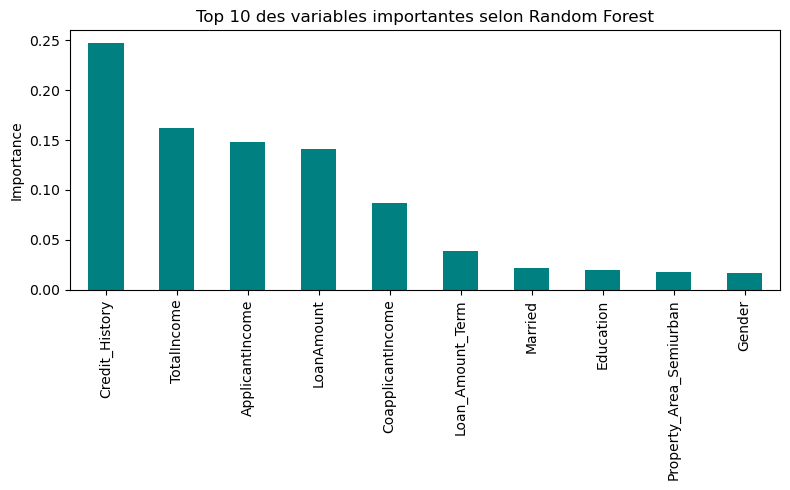

In [46]:
# Entraînement d'un Random Forest pour estimer l'importance des variables
rf_selector = RandomForestClassifier(random_state=42, n_estimators=100)
rf_selector.fit(X_train_processed_df, y_train_encoded)

# Importance des features
importances = rf_selector.feature_importances_
feat_importances = pd.Series(importances, index=X_train_processed_df.columns)
feat_importances_sorted = feat_importances.sort_values(ascending=False)

# Affichage du top 10 des variables importantes
plt.figure(figsize=(8,5))
feat_importances_sorted.head(10).plot(kind='bar', color='teal')
plt.title("Top 10 des variables importantes selon Random Forest")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# Sélection des variables importantes (par exemple : importance > 0.02)
selected_features_rf = feat_importances_sorted[feat_importances_sorted > 0.02].index.tolist()



Avant de passer à la sélection automatique, nous avons déjà réalisé :
- une **analyse de corrélation** pour les variables numériques, afin d’identifier celles qui sont le plus liées à la cible,
- un **test du chi²** pour les variables catégorielles, pour repérer celles qui présentent une association statistiquement significative avec la décision d’octroi.

<p align="right">Pour aller plus loin, nous utilisons ici l’algorithme Random Forest, qui permet d’estimer l’importance de chaque variable dans la prédiction, en tenant compte des interactions et des relations complexes entre les variables.

Après l’entraînement du modèle, nous avons extrait et visualisé les variables les plus influentes.  
Celles dont l’importance dépasse un certain seuil (ici 0.02) sont retenues pour la suite de l’analyse.  
Cette approche croisée (statistiques classiques + machine learning) permet de sélectionner de façon robuste et justifiée les variables explicatives les plus pertinentes.

Voici la liste des 10 variables les plus importantes sélectionnées par Random Forest :

1. **Credit_History**
2. **TotalIncome**
3. **ApplicantIncome**
4. **LoanAmount**
5. **CoapplicantIncome**
6. **Loan_Amount_Term**
7. **Married**
8. **Education**
9. **Property_Area_Semiurban**
10. **Gender**

On constate que l’**historique de crédit** et les **revenus** (total, du demandeur et du coemprunteur) sont les facteurs déterminants pour la décision d’octroi.  
Des variables comme la durée du prêt, le statut marital, le niveau d’éducation, la zone géographique et le genre jouent également un rôle, mais de façon plus modérée.

En résumé, Random Forest complète et confirme les premiers résultats statistiques, tout en détectant d’éventuelles relations non linéaires ou interactions subtiles entre les variables.</p>


### Rééquilibrage des classes avec SMOTE

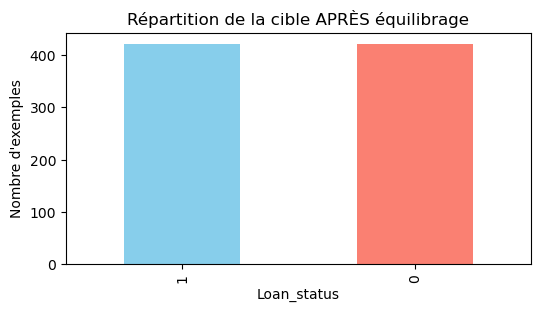

In [47]:
# Rééquilibrage avec SMOTE sur les variables sélectionnées
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_processed_df[selected_features_rf], y_train_encoded)

# Visualisation de la nouvelle distribution de la cible
plt.figure(figsize=(6,3))
pd.Series(y_resampled).value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Répartition de la cible APRÈS équilibrage")
plt.xlabel("Loan_status")
plt.ylabel("Nombre d'exemples")
plt.show()


<p align="right">Dans notre jeu de données, la variable cible (`Loan_Status`) était déséquilibrée : la classe "prêt accordé" était beaucoup plus représentée que la classe "prêt refusé".  
Ce déséquilibre peut biaiser les modèles de machine learning, qui auront tendance à privilégier la classe majoritaire.

Pour corriger ce problème, nous avons utilisé la technique **SMOTE** (Synthetic Minority Over-sampling Technique).  
SMOTE génère de nouveaux exemples synthétiques pour la classe minoritaire, en interpolant entre les observations existantes, ce qui permet d’obtenir un jeu de données équilibré sans simplement dupliquer les exemples.

La visualisation ci-dessous montre la répartition de la variable cible après application de SMOTE : les deux classes sont désormais représentées de façon équitable, ce qui permettra d’entraîner des modèles plus justes et performants.

Ce rééquilibrage est particulièrement important pour améliorer la capacité du modèle à bien prédire les cas de prêt refusé, souvent plus rares et pourtant essentiels dans une logique de gestion du risque.</p>


### Modelisation avec les variables selectionnées

Nous abordons à présent la phase de modélisation, où différents algorithmes de machine learning seront testés afin de prédire l’octroi de prêt.

Pour garantir la robustesse et la fiabilité de nos résultats, nous utilisons la **validation croisée à 5 folds** (*5-fold cross-validation*).  
La validation croisée consiste à diviser le jeu de données en 5 sous-ensembles de taille équivalente : à chaque itération, le modèle est entraîné sur 4 folds et testé sur le fold restant. Ce processus est répété 5 fois, chaque fold servant une fois de jeu de test. Les scores obtenus sont ensuite moyennés pour fournir une estimation fiable et moins biaisée des performances du modèle sur des données inédites.

Dans cette étude, nous avons utilisé et comparé les 4 modèles suivants :
- **Random Forest**
- **Gradient Boosting**
- **Régression logistique**
- **Naive bayes**

Pour chaque méthode, nous présenterons systématiquement :
- la **matrice de confusion**, qui détaille la répartition des prédictions correctes et incorrectes pour chaque classe ;
- la **courbe ROC**, qui permet d’évaluer la capacité du modèle à distinguer les classes, quel que soit le seuil de décision ;
- les **principales métriques de performance** :  
  - **Accuracy**: proportion de prédictions correctes sur l’ensemble du jeu de test,
  - **F1-score**: moyenne harmonique entre la précision et le rappel, utile en cas de classes déséquilibrées,
  - **ROC AUC**: mesure de la capacité du modèle à distinguer les deux classes,
  - **Précision**, **Rappel**, **F1-score** et **Support** pour chaque classe, afin d’avoir une vision détaillée de la performance sur les prêts accordés et refusés.

À l’issue de ces évaluations, nous sélectionnerons le modèle offrant les meilleures performances globales pour la prédiction de l’octroi de prêt.


### Random forest

Accuracy moyenne (cross-validation 5-fold): 0.8081
Scores pour chaque fold: [0.75739645 0.81656805 0.85798817 0.79289941 0.81547619]
Accuracy : 0.834319526627219
F1-score : 0.8494623655913979
ROC AUC : 0.9084033613445377
              precision    recall  f1-score   support

           0       0.93      0.73      0.82        85
           1       0.77      0.94      0.85        84

    accuracy                           0.83       169
   macro avg       0.85      0.83      0.83       169
weighted avg       0.85      0.83      0.83       169



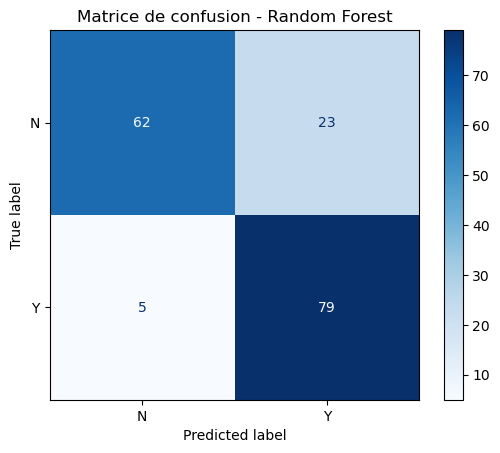

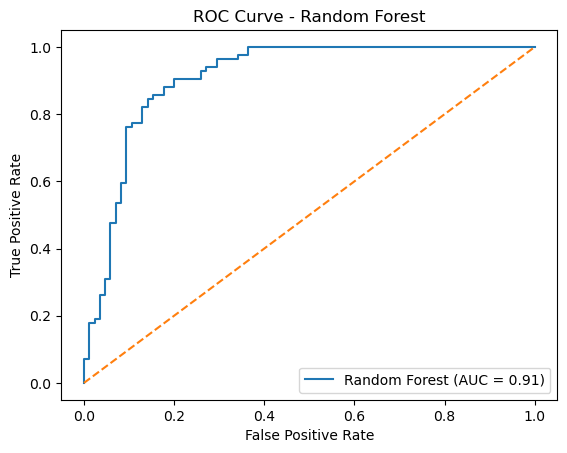

In [48]:
rf = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=7,
    min_samples_leaf=4,
    min_samples_split=5
)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    rf, X_resampled, y_resampled, cv=cv, scoring='accuracy'
)
print(f"Accuracy moyenne (cross-validation 5-fold): {cv_scores.mean():.4f}")
print(f"Scores pour chaque fold: {cv_scores}")

# Split train/validation
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Entraînement et évaluation
rf.fit(X_train_final, y_train_final)
y_pred_rf = rf.predict(X_val)
y_proba_rf = rf.predict_proba(X_val)[:, 1]
print("Accuracy :", accuracy_score(y_val, y_pred_rf))
print("F1-score :", f1_score(y_val, y_pred_rf))
print("ROC AUC :", roc_auc_score(y_val, y_proba_rf))
print(classification_report(y_val, y_pred_rf))
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_rf, display_labels=label_encoder_target.classes_, cmap='Blues')
plt.title("Matrice de confusion - Random Forest")
plt.show()
fpr, tpr, _ = roc_curve(y_val, y_proba_rf)
plt.plot(fpr, tpr, label='Random Forest (AUC = %.2f)' % roc_auc_score(y_val, y_proba_rf))
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()


Le modèle Random Forest présente des performances solides, en particulier pour la détection des prêts éligibles.

* **Accuracy Moyenne (Cross-Validation 5-fold) : 0.8081**
    * Ce score représente la précision moyenne du modèle sur 5 sous-ensembles différents des données d'entraînement, indiquant une bonne capacité de généralisation (80.81%).
* **Accuracy (Validation) : 0.8343**
    * La précision sur notre ensemble de validation dédié est de 83.43%, ce qui signifie que 83.43% des prédictions du modèle sur ces données sont correctes.
* **F1-score (Validation) : 0.8495**
    * Le F1-score (84.95%) indique un bon équilibre entre la précision et le rappel, utile en cas de classes déséquilibrées.
* **ROC AUC (Validation) : 0.9084**
    * L'AUC de 0.9084 est excellent, suggérant que le modèle est très bon pour différencier les demandeurs éligibles des non-éligibles.

**Matrice de Confusion (Validation) :**

|                 | Prédit Non-Éligible (0) | Prédit Éligible (1) |
| :-------------- | :---------------------: | :-----------------: |
| **Réel Non-Éligible (0)** | **62 (Vrais Négatifs)** | **23 (Faux Positifs)** |
| **Réel Éligible (1)** | **5 (Faux Négatifs)** | **79 (Vrais Positifs)** |

* **Vrais Positifs (VP = 79) :** Le modèle a correctement prédit 79 clients comme étant éligibles (classe 1) et ils l'étaient réellement.
* **Vrais Négatifs (VN = 62) :** Le modèle a correctement prédit 62 clients comme étant non-éligibles (classe 0) et ils ne l'étaient pas réellement.
* **Faux Positifs (FP = 23) :** Le modèle a prédit 23 clients comme étant éligibles (classe 1), mais ils étaient en réalité non-éligibles (classe 0). C'est un risque pour la banque.
* **Faux Négatifs (FN = 5) :** Le modèle a prédit 5 clients comme étant non-éligibles (classe 0), mais ils étaient en réalité éligibles (classe 1). C'est une opportunité manquée pour la banque.

**Analyse du Rapport de Classification :**

| Classe      | Précision | Rappel | F1-score | Support |
| :---------- | :-------- | :----- | :------- | :------ |
| 0 (Non-éligible) | 0.93      | 0.73   | 0.82     | 85      |
| 1 (Éligible) | 0.77      | 0.94   | 0.85     | 84      |

* **Classe 0 (Non-éligible) :**
    * **Précision (0.93) :** Sur 85 clients prédits non-éligibles (62 VN + 23 FP), 93% l'étaient réellement. Le modèle est fiable lorsqu'il identifie un risque.
    * **Rappel (0.73) :** Sur les 85 clients réellement non-éligibles, le modèle en a détecté 73%. Il manque 27% des risques.
* **Classe 1 (Éligible) :**
    * **Précision (0.77) :** Sur 84 clients prédits éligibles (79 VP + 5 FN), 77% l'étaient réellement. Cela signifie que 23% des prédictions positives étaient fausses (faux positifs).
    * **Rappel (0.94) :** Sur les 84 clients réellement éligibles, le modèle en a détecté 94%. Il est excellent pour identifier les bons clients.

En résumé, le Random Forest excelle à identifier la majorité des clients éligibles et est très fiable quand il identifie un risque, mais il génère un nombre notable de faux positifs et manque une partie des vrais non-éligibles.

### Gradient boosting

Accuracy moyenne (cross-validation 5-fold): 0.8010
Scores pour chaque fold: [0.74556213 0.84615385 0.82840237 0.78106509 0.80357143]
Accuracy (validation): 0.8461538461538461
F1-score (validation): 0.8470588235294118
ROC AUC (validation): 0.911484593837535
              precision    recall  f1-score   support

           0       0.86      0.84      0.85        85
           1       0.84      0.86      0.85        84

    accuracy                           0.85       169
   macro avg       0.85      0.85      0.85       169
weighted avg       0.85      0.85      0.85       169



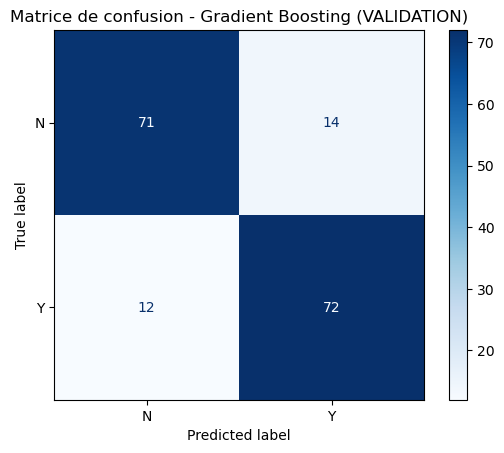

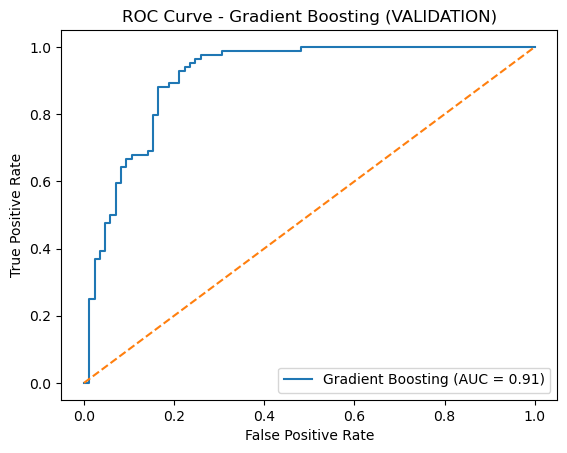

In [49]:
gb = GradientBoostingClassifier(
    n_estimators=200,
    max_depth=7,
    min_samples_leaf=4,
    min_samples_split=5,
    random_state=42
)
cv_scores_gb = cross_val_score(
    gb, X_resampled, y_resampled, cv=cv, scoring='accuracy'
)
print(f"Accuracy moyenne (cross-validation 5-fold): {cv_scores_gb.mean():.4f}")
print(f"Scores pour chaque fold: {cv_scores_gb}")

gb.fit(X_train_final, y_train_final)
y_pred_gb = gb.predict(X_val)
y_proba_gb = gb.predict_proba(X_val)[:, 1]
print("Accuracy (validation):", accuracy_score(y_val, y_pred_gb))
print("F1-score (validation):", f1_score(y_val, y_pred_gb))
print("ROC AUC (validation):", roc_auc_score(y_val, y_proba_gb))
print(classification_report(y_val, y_pred_gb))
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_gb, display_labels=label_encoder_target.classes_, cmap='Blues')
plt.title("Matrice de confusion - Gradient Boosting (VALIDATION)")
plt.show()
fpr, tpr, _ = roc_curve(y_val, y_proba_gb)
plt.plot(fpr, tpr, label='Gradient Boosting (AUC = %.2f)' % roc_auc_score(y_val, y_proba_gb))
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Gradient Boosting (VALIDATION)")
plt.legend()
plt.show()


Le Gradient Boosting se distingue comme un modèle très performant, offrant un excellent équilibre entre précision et rappel pour les deux classes.

* **Accuracy Moyenne (Cross-Validation 5-fold) : 0.8010**
    * Une précision moyenne de 80.10% en validation croisée, témoignant d'une bonne capacité du modèle à généraliser et d'une bonne stabilité.
* **Accuracy (Validation) : 0.8462**
    * Sur l'ensemble de validation, le modèle atteint une précision de 84.62%, la plus élevée parmi les modèles testés.
* **F1-score (Validation) : 0.8471**
    * Avec un F1-score de 84.71%, le Gradient Boosting maintient un très bon équilibre entre la précision et le rappel pour l'ensemble des classes.
* **ROC AUC (Validation) : 0.9115**
    * Le ROC AUC de 0.9115 est le plus élevé de tous les modèles, indiquant une capacité supérieure à distinguer les classes positives des classes négatives.

**Matrice de Confusion (Validation) :**

|                 | Prédit Non-Éligible (0) | Prédit Éligible (1) |
| :-------------- | :---------------------: | :-----------------: |
| **Réel Non-Éligible (0)** | **71 (Vrais Négatifs)** | **14 (Faux Positifs)** |
| **Réel Éligible (1)** | **12 (Faux Négatifs)** | **72 (Vrais Positifs)** |

* **Vrais Positifs (VP = 72) :** Le modèle a correctement prédit 72 clients comme étant éligibles.
* **Vrais Négatifs (VN = 71) :** Le modèle a correctement prédit 71 clients comme étant non-éligibles.
* **Faux Positifs (FP = 14) :** Le modèle a prédit 14 clients comme étant éligibles, mais ils étaient en réalité non-éligibles. C'est un coût potentiel pour la banque.
* **Faux Négatifs (FN = 12) :** Le modèle a prédit 12 clients comme étant non-éligibles, mais ils étaient en réalité éligibles. C'est une opportunité manquée pour la banque.

**Analyse du Rapport de Classification :**

| Classe      | Précision | Rappel | F1-score | Support |
| :---------- | :-------- | :----- | :------- | :------ |
| 0 (Non-éligible) | 0.86      | 0.84   | 0.85     | 85      |
| 1 (Éligible) | 0.84      | 0.86   | 0.85     | 84      |

* **Classe 0 (Non-éligible) :**
    * **Précision (0.86) :** 86% des clients prédits non-éligibles le sont réellement.
    * **Rappel (0.84) :** Le modèle détecte 84% des clients réellement non-éligibles, montrant une bonne capacité à identifier les risques.
* **Classe 1 (Éligible) :**
    * **Précision (0.84) :** 84% des clients prédits éligibles le sont réellement.
    * **Rappel (0.86) :** Le modèle détecte 86% des clients réellement éligibles.

Le Gradient Boosting présente une performance très équilibrée et minimisée à la fois les faux positifs et les faux négatifs, ce qui le rend très fiable dans la prise de décision.

### Regression logistique


=== Logistic Regression ===
Accuracy moyenne (cross-validation 5-fold): 0.7560
Scores pour chaque fold: [0.71005917 0.75147929 0.77514793 0.73964497 0.80357143]
Accuracy (validation): 0.7633136094674556
F1-score (validation): 0.801980198019802
ROC AUC (validation): 0.8109243697478992
              precision    recall  f1-score   support

           0       0.94      0.56      0.71        85
           1       0.69      0.96      0.80        84

    accuracy                           0.76       169
   macro avg       0.81      0.76      0.75       169
weighted avg       0.81      0.76      0.75       169



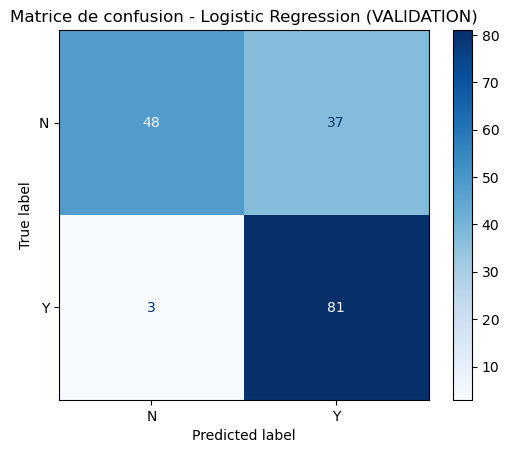

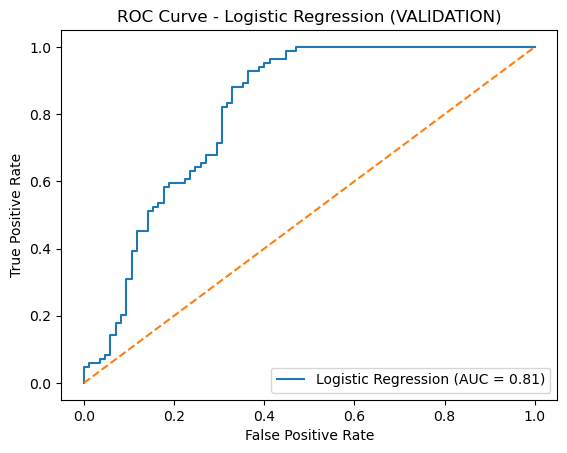

Accuracy moyenne (cross-validation 5-fold): 0.7560
Scores pour chaque fold: [0.71005917 0.75147929 0.77514793 0.73964497 0.80357143]

--- Évaluation sur la VALIDATION ---
Accuracy (validation): 0.7633136094674556
F1-score (validation): 0.801980198019802
ROC AUC (validation): 0.8109243697478992

Classification report :
              precision    recall  f1-score   support

           0       0.94      0.56      0.71        85
           1       0.69      0.96      0.80        84

    accuracy                           0.76       169
   macro avg       0.81      0.76      0.75       169
weighted avg       0.81      0.76      0.75       169



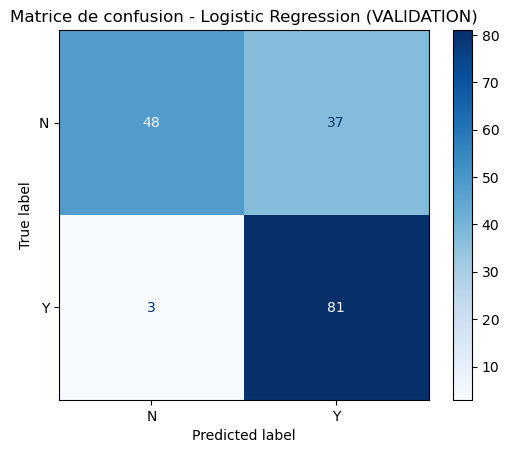

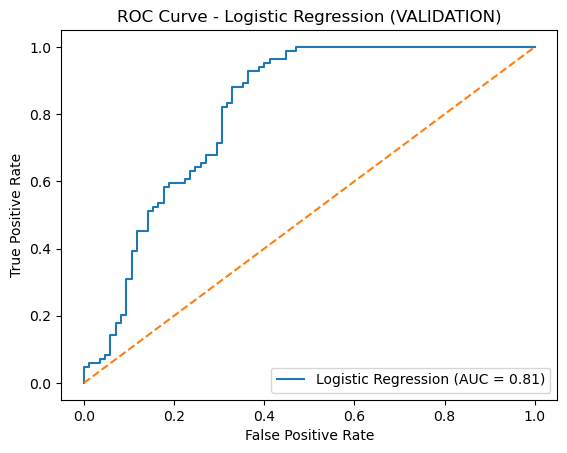

In [50]:
print("\n=== Logistic Regression ===")

# 1. Définition du modèle (sans class_weight='balanced')
lr = LogisticRegression(
    max_iter=1000,
    random_state=42  # Suppression de class_weight car SMOTE a déjà équilibré
)
lr = LogisticRegression(max_iter=1000, random_state=42)
cv_scores_lr = cross_val_score(
    lr, X_resampled, y_resampled, cv=cv, scoring='accuracy'
)
print(f"Accuracy moyenne (cross-validation 5-fold): {cv_scores_lr.mean():.4f}")
print(f"Scores pour chaque fold: {cv_scores_lr}")

lr.fit(X_train_final, y_train_final)
y_pred_lr = lr.predict(X_val)
y_proba_lr = lr.predict_proba(X_val)[:,1]
print("Accuracy (validation):", accuracy_score(y_val, y_pred_lr))
print("F1-score (validation):", f1_score(y_val, y_pred_lr))
print("ROC AUC (validation):", roc_auc_score(y_val, y_proba_lr))
print(classification_report(y_val, y_pred_lr))
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_lr, display_labels=label_encoder_target.classes_, cmap='Blues')
plt.title("Matrice de confusion - Logistic Regression (VALIDATION)")
plt.show()
fpr, tpr, _ = roc_curve(y_val, y_proba_lr)
plt.plot(fpr, tpr, label='Logistic Regression (AUC = %.2f)' % roc_auc_score(y_val, y_proba_lr))
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression (VALIDATION)")
plt.legend()
plt.show()

# 2. Validation croisée sur les DONNÉES RÉÉQUILIBRÉES
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_lr = cross_val_score(
    lr, 
    X_resampled,  # <-- Données rééquilibrées
    y_resampled,  # <-- Cible rééquilibrée
    cv=cv, 
    scoring='accuracy'
)
print(f"Accuracy moyenne (cross-validation 5-fold): {cv_scores_lr.mean():.4f}")
print(f"Scores pour chaque fold: {cv_scores_lr}")

# 3. Séparation entraînement/validation (80/20)
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_resampled, 
    y_resampled, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_resampled
)

# 4. Entraînement sur le train final rééquilibré
lr.fit(X_train_final, y_train_final)

# 5. Prédiction et évaluation sur la validation
y_pred_lr = lr.predict(X_val)
y_proba_lr = lr.predict_proba(X_val)[:,1]

print("\n--- Évaluation sur la VALIDATION ---")
print("Accuracy (validation):", accuracy_score(y_val, y_pred_lr))
print("F1-score (validation):", f1_score(y_val, y_pred_lr))
print("ROC AUC (validation):", roc_auc_score(y_val, y_proba_lr))
print("\nClassification report :")
print(classification_report(y_val, y_pred_lr))

# Matrice de confusion
ConfusionMatrixDisplay.from_predictions(
    y_val,  # <-- Validation au lieu de train
    y_pred_lr, 
    display_labels=label_encoder_target.classes_, 
    cmap='Blues'
)
plt.title("Matrice de confusion - Logistic Regression (VALIDATION)")
plt.show()

# Courbe ROC
fpr, tpr, _ = roc_curve(y_val, y_proba_lr)
plt.plot(fpr, tpr, label='Logistic Regression (AUC = %.2f)' % roc_auc_score(y_val, y_proba_lr))
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression (VALIDATION)")
plt.legend()
plt.show()


La Régression Logistique, bien que plus simple, montre des performances acceptables mais avec des déséquilibres notables entre précision et rappel, particulièrement visible dans sa matrice de confusion.

* **Accuracy Moyenne (Cross-Validation 5-fold) : 0.7560**
    * Une précision moyenne de 75.60% en validation croisée, indiquant une performance modérée par rapport aux modèles ensemblistes.
* **Accuracy (Validation) : 0.7633**
    * La précision sur l'ensemble de validation est de 76.33%.
* **F1-score (Validation) : 0.8020**
    * Le F1-score de 80.20% est correct, mais il masque un déséquilibre important entre précision et rappel pour chaque classe.
* **ROC AUC (Validation) : 0.8109**
    * Le ROC AUC de 0.8109 est significativement inférieur aux modèles basés sur les arbres, ce qui suggère une capacité de discrimination plus limitée.

**Matrice de Confusion (Validation) :**

|                 | Prédit Non-Éligible (0) | Prédit Éligible (1) |
| :-------------- | :---------------------: | :-----------------: |
| **Réel Non-Éligible (0)** | **48 (Vrais Négatifs)** | **37 (Faux Positifs)** |
| **Réel Éligible (1)** | **3 (Faux Négatifs)** | **81 (Vrais Positifs)** |

* **Vrais Positifs (VP = 81) :** Le modèle a correctement prédit 81 clients comme étant éligibles.
* **Vrais Négatifs (VN = 48) :** Le modèle a correctement prédit 48 clients comme étant non-éligibles.
* **Faux Positifs (FP = 37) :** Le modèle a prédit 37 clients comme étant éligibles, mais ils étaient en réalité non-éligibles. C'est un **nombre élevé de faux positifs**, ce qui représente un risque financier significatif pour la banque.
* **Faux Négatifs (FN = 3) :** Le modèle a prédit 3 clients comme étant non-éligibles, mais ils étaient en réalité éligibles. C'est un **très faible nombre de faux négatifs**, signifiant qu'il manque très peu d'opportunités.

**Analyse du Rapport de Classification :**

| Classe      | Précision | Rappel | F1-score | Support |
| :---------- | :-------- | :----- | :------- | :------ |
| 0 (Non-éligible) | 0.94      | 0.56   | 0.71     | 85      |
| 1 (Éligible) | 0.69      | 0.96   | 0.80     | 84      |

* **Classe 0 (Non-éligible) :**
    * **Précision (0.94) :** Très élevée. Lorsqu'il prédit un non-éligible, le modèle est très fiable.
    * **Rappel (0.56) :** Très faible. Le modèle ne détecte qu'environ la moitié des clients réellement non-éligibles.
* **Classe 1 (Éligible) :**
    * **Précision (0.69) :** Relativement faible. Près d'un tiers des prédictions "éligible" sont incorrectes.
    * **Rappel (0.96) :** Excellent. Le modèle détecte presque tous les clients réellement éligibles.

En conclusion, la Régression Logistique est très bonne pour identifier les bons clients mais au prix d'un nombre élevé de faux positifs et d'une incapacité à identifier une proportion significative de clients à risque.

#### Naive bayes

Accuracy moyenne (cross-validation 5-fold): 0.7441
Scores pour chaque fold: [0.68639053 0.74556213 0.76331361 0.72781065 0.79761905]
Accuracy (validation): 0.7514792899408284
F1-score (validation): 0.7941176470588235
ROC AUC (validation): 0.788235294117647
              precision    recall  f1-score   support

           0       0.94      0.54      0.69        85
           1       0.68      0.96      0.79        84

    accuracy                           0.75       169
   macro avg       0.81      0.75      0.74       169
weighted avg       0.81      0.75      0.74       169



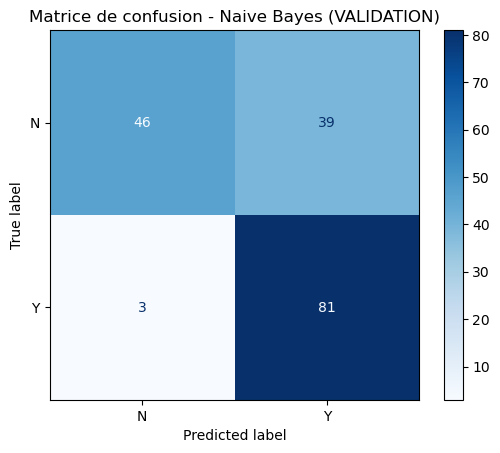

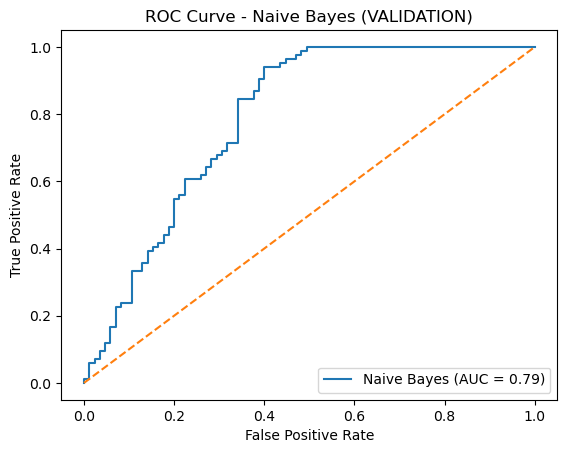

In [51]:
nb = GaussianNB()
cv_scores_nb = cross_val_score(
    nb, X_resampled, y_resampled, cv=cv, scoring='accuracy'
)
print(f"Accuracy moyenne (cross-validation 5-fold): {cv_scores_nb.mean():.4f}")
print(f"Scores pour chaque fold: {cv_scores_nb}")

nb.fit(X_train_final, y_train_final)
y_pred_nb = nb.predict(X_val)
y_proba_nb = nb.predict_proba(X_val)[:,1]
print("Accuracy (validation):", accuracy_score(y_val, y_pred_nb))
print("F1-score (validation):", f1_score(y_val, y_pred_nb))
print("ROC AUC (validation):", roc_auc_score(y_val, y_proba_nb))
print(classification_report(y_val, y_pred_nb))
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_nb, display_labels=label_encoder_target.classes_, cmap='Blues')
plt.title("Matrice de confusion - Naive Bayes (VALIDATION)")
plt.show()
fpr, tpr, _ = roc_curve(y_val, y_proba_nb)
plt.plot(fpr, tpr, label='Naive Bayes (AUC = %.2f)' % roc_auc_score(y_val, y_proba_nb))
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Naive Bayes (VALIDATION)")
plt.legend()
plt.show()


Le modèle Naive Bayes, bien que simple et rapide, affiche les performances les plus modestes parmi les modèles testés et présente un déséquilibre marqué.

* **Accuracy Moyenne (Cross-Validation 5-fold) : 0.7441**
    * La précision moyenne en validation croisée est de 74.41%, la plus basse des modèles, suggérant une moindre robustesse.
* **Accuracy (Validation) : 0.7515**
    * La précision sur l'ensemble de validation est de 75.15%.
* **F1-score (Validation) : 0.7941**
    * Un F1-score de 79.41%, acceptable, mais qui masque un déséquilibre important dans les performances par classe.
* **ROC AUC (Validation) : 0.7882**
    * Le ROC AUC de 0.7882 est le plus bas, indiquant une capacité de discrimination limitée par rapport aux autres modèles.

**Matrice de Confusion (Validation) :**

|                 | Prédit Non-Éligible (0) | Prédit Éligible (1) |
| :-------------- | :---------------------: | :-----------------: |
| **Réel Non-Éligible (0)** | **46 (Vrais Négatifs)** | **39 (Faux Positifs)** |
| **Réel Éligible (1)** | **3 (Faux Négatifs)** | **81 (Vrais Positifs)** |

* **Vrais Positifs (VP = 81) :** Le modèle a correctement prédit 81 clients comme étant éligibles.
* **Vrais Négatifs (VN = 46) :** Le modèle a correctement prédit 46 clients comme étant non-éligibles.
* **Faux Positifs (FP = 39) :** Le modèle a prédit 39 clients comme étant éligibles, mais ils étaient en réalité non-éligibles. C'est le **plus grand nombre de faux positifs** de tous les modèles, représentant un risque financier élevé.
* **Faux Négatifs (FN = 3) :** Le modèle a prédit 3 clients comme étant non-éligibles, mais ils étaient en réalité éligibles. C'est un **très faible nombre de faux négatifs**, indiquant qu'il manque très peu d'opportunités.

**Analyse du Rapport de Classification :**

| Classe      | Précision | Rappel | F1-score | Support |
| :---------- | :-------- | :----- | :------- | :------ |
| 0 (Non-éligible) | 0.94      | 0.54   | 0.69     | 85      |
| 1 (Éligible) | 0.68      | 0.96   | 0.79     | 84      |

* **Classe 0 (Non-éligible) :**
    * **Précision (0.94) :** Très élevée. Le modèle est très fiable lorsqu'il prédit un non-éligible.
    * **Rappel (0.54) :** Le plus faible. Il manque près de la moitié des clients réellement non-éligibles.
* **Classe 1 (Éligible) :**
    * **Précision (0.68) :** La plus basse. Plus d'un tiers des prédictions "éligible" sont incorrectes.
    * **Rappel (0.96) :** Excellent. Le modèle détecte presque tous les clients réellement éligibles.

Naive Bayes est caractérisé par sa simplicité et sa rapidité, mais ses performances sont inférieures, et il montre un très fort biais en faveur de la prédiction des clients éligibles, générant de nombreux faux positifs et manquant une grande proportion de clients à risque.

### Choix du meilleur modéle 

Après une analyse approfondie des performances de nos quatre classifieurs, en évaluant les métriques clés et en interprétant les matrices de confusion, nous pouvons identifier le modèle le plus adapté à notre problème de prédiction de l'éligibilité aux prêts.

**Classement des modèles par ROC AUC (capacité globale de discrimination) :**

1.  **Gradient Boosting Classifier : 0.9115**
2.  **Random Forest Classifier : 0.9084**
3.  **Régression Logistique : 0.8109**
4.  **Naive Bayes : 0.7882**

**Analyse Comparative Approfondie des Matrices de Confusion et des Métriques :**

* **Modèles Ensemblistes (Gradient Boosting et Random Forest) :**
    * Ces deux modèles démontrent une **performance globale nettement supérieure** (ROC AUC > 0.90) et une meilleure robustesse en validation croisée.
    * Le **Gradient Boosting** se distingue par un **excellent équilibre** entre la détection des **Vrais Positifs (72)** et des **Vrais Négatifs (71)**, tout en maintenant un **nombre réduit de Faux Positifs (14)** et de **Faux Négatifs (12)**. Ses scores de Précision et Rappel sont équilibrés autour de 0.85 pour les deux classes. Il excelle à la fois pour identifier les bons clients et pour identifier les risques.
    * Le **Random Forest** est très proche, avec un **très haut nombre de Vrais Positifs (79)** et un **très faible nombre de Faux Négatifs (5)**. Cela signifie qu'il est exceptionnel pour ne manquer aucun bon client. Cependant, il génère un **nombre plus élevé de Faux Positifs (23)** que le Gradient Boosting, ce qui pourrait être un désavantage si l'on veut minimiser les prêts à risque.

* **Modèles Simples (Régression Logistique et Naive Bayes) :**
    * Ces modèles affichent des **performances inférieures** (ROC AUC < 0.82) et des déséquilibres marqués dans leurs matrices de confusion.
    * Tous deux ont un **nombre très élevé de Vrais Positifs (81)** et un **nombre très faible de Faux Négatifs (3)**, signifiant qu'ils sont très efficaces pour ne pas rejeter les bons clients.
    * Cependant, cela se fait au prix d'un **nombre très élevé de Faux Positifs** (37 pour Régression Logistique, 39 pour Naive Bayes). Cela signifie qu'ils octroient des prêts à un grand nombre de clients qui devraient être refusés, augmentant considérablement le risque pour la banque. Leurs faibles Rappels pour la classe "non-éligible" le confirment.

**Meilleur Modèle :**

Compte tenu de la nécessité d'un équilibre entre la minimisation des risques financiers (limiter les faux positifs) et la détection des opportunités (maximiser les vrais positifs), le **Gradient Boosting Classifier** est le **meilleur modèle** pour ce projet de classification.

Son **ROC AUC le plus élevé**, combiné à l'**équilibre remarquable** de ses performances sur la matrice de confusion (faible nombre de faux positifs et de faux négatifs), en fait le choix le plus robuste et le plus fiable pour prédire l'éligibilité aux prêts. Il permet une prise de décision équilibrée et minimise les deux types d'erreurs coûteuses.

### Optimisation par GridSearch du meilleur modèle( Gradient Boosting)

In [52]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
gb = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=gb,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_resampled, y_resampled)
print("Meilleurs paramètres :", grid_search.best_params_)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Meilleurs paramètres : {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


Après avoir identifié le Gradient Boosting comme le meilleur modèle pour notre problématique, nous avons cherché à optimiser ses performances en ajustant ses hyperparamètres clés.

Pour cela, nous avons utilisé la méthode **GridSearchCV** :  
- GridSearchCV permet d’explorer de façon systématique toutes les combinaisons possibles d’un ensemble d’hyperparamètres définis à l’avance.
- Pour chaque combinaison, le modèle est évalué à l’aide d’une validation croisée (ici, 5 folds), en utilisant le score ROC AUC comme critère principal de sélection.
- Cette approche garantit que le modèle final est non seulement performant, mais aussi robuste et généralisable.

Les hyperparamètres testés incluent :
- **n_estimators** : nombre d’arbres dans l’ensemble,
- **learning_rate** : taux d’apprentissage,
- **max_depth** : profondeur maximale des arbres,
- **min_samples_split** : nombre minimum d’échantillons pour diviser un nœud,
- **min_samples_leaf** : nombre minimum d’échantillons dans une feuille.

À l’issue du GridSearch, nous retenons la combinaison d’hyperparamètres qui maximise le score ROC AUC en validation croisée.  
Cette étape d’optimisation est essentielle pour tirer le meilleur parti du Gradient Boosting et garantir des prédictions fiables sur de nouvelles données.


### Prédictions finales et export

In [53]:
# Prédictions sur le test final avec le meilleur modèle
best_gb = grid_search.best_estimator_
best_gb.fit(X_resampled, y_resampled)
y_test_pred_best = best_gb.predict(X_test_processed_df[selected_features])
y_test_pred_best_label = label_encoder_target.inverse_transform(y_test_pred_best)
print("Aperçu des prédictions test (Gradient Boosting optimisé) :")
print(y_test_pred_best_label[:30])

# Sauvegarde des résultats pour soumission
df_submission = pd.DataFrame({
    'Loan_Status': y_test_pred_best_label
})
df_submission.to_csv('loan_predictions_gb_optimise.csv', index=False)


NameError: name 'X_test_processed_df' is not defined

Après optimisation des hyperparamètres du Gradient Boosting via GridSearchCV, nous avons retenu le meilleur modèle pour réaliser les prédictions finales sur le jeu de test.

Le modèle optimisé a été réentraîné sur l’ensemble des données rééquilibrées, puis appliqué au jeu de test prétraité.  
Les prédictions obtenues correspondent à la variable cible (`Loan_Status`) et sont prêtes à être soumises pour évaluation finale.

Enfin, les résultats ont été enregistrés dans un fichier CSV (`loan_predictions_gb_optimise.csv`) au format attendu pour la soumission.

Cette étape conclut le workflow de modélisation, de l’optimisation à la production des prédictions finales exploitables.


### Conclusion 

Dans ce premier notebook consacré à la **classification**, nous avons mené à bien toutes les étapes nécessaires à la construction d’un modèle prédictif fiable pour l’éligibilité à un prêt bancaire.

Grâce à un prétraitement minutieux des données, à une sélection rigoureuse des variables et à la comparaison de plusieurs algorithmes de classification, nous avons pu identifier le modèle le plus performant pour notre problématique : le **Gradient Boosting Classifier**. Son équilibre entre détection des bons clients et limitation des risques en fait un choix pertinent pour un usage opérationnel.

Ce travail nous a permis de renforcer nos compétences en data science, aussi bien sur les aspects techniques (feature engineering, validation croisée, optimisation d’hyperparamètres) que sur l’interprétation métier des résultats.

Nous clôturons ainsi la partie classification de notre projet.  
La prochaine étape consistera à explorer la **régression** pour prédire le montant du prêt à octroyer.